# Socrata Metadata Completion Assessment 

## Creates charts, tables, and csv files summarizing assets on a Socrata Portal

This should work for any socrata portal, but you'll need to adjust the custom values in the metadata completeness sections

Probably need to get a token to be able to download all the data.  Right now the API call specifies the number of assets so it still works. Otherwise it only returns 100

In [29]:
#import the required libraries
import os
import csv
import requests
import json as json
from pandas.io.json import json_normalize
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns


## Set up the code for your portal of interest

In [30]:
targeturl='https://data.wa.gov/' #change this to the SOCRATA portal you want to target, don't forget ending /
domain='data.wa.gov' 
descriptor='WA'   #change this to a recognizable descriptor for yourself- used in csv filename
downloadDate = datetime.datetime.now()

### OPTIONAL: If you want to use a json file you've already downloaded, open the json file with testing data
Use this if you need to test code.  Find the json file name in your working directory

In [33]:
#Open up the same file for reading
with open("WA-basicMETADATA2019-08-20.json", "r") as read_file: #Replace this with the filename of your choice
    d = json.load(read_file)
count=len(d)

In [32]:
#OPTIONAL!!!
# Using list comprehension to delete dictionary in list that contains 'reportcard'. 
#If you want the full dataset, skip this step
# All scripts below use 'd' as the source data
d = [i for i in d if 'reportcard' not in (i['classification']['domain_tags'])]
print(len(d),',', count-len(d), 'assets removed')

2251 , 425 assets removed


## Create Dictionary json records
Use the Socrata API to get ALL metadata for the public assets
If you do not have a token, go to the portal you are assessing and get the total number of assests, insert that into the "?limit=(number of assets)" part of the url string.
If you have a token delete "?limit=2672" and add "?$$app_token=[your token]" to the end

In [3]:
r=requests.get('http://api.us.socrata.com/api/catalog/v1?limit=2616&domains='+domain) #build string according to SOCRATA's convention to get public data assets
#r=requests.get('http://api.us.socrata.com/api/catalog/v1?domains='+domain) #build string according to SOCRATA's convention to get public data assets
j=json.loads(r.text) #parse the json into a list named j
j=[i for i in j['results']] #This gets rid of the 'results' key

### Save the json to a file so you don't have to keep downloading it everytime.

In [4]:
#j[0] #view the first record
with open(descriptor+'-basicMETADATA'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.json', "w") as write_file:
    json.dump(j, write_file)
d = j
count = len(d)

### OPTIONAL: If you want to delete any assets by tags, use this:

In [7]:
# Using list comprehension to delete dictionary in list that contains 'reportcard'. 
#If you want the full dataset, skip this step
# All scripts below use 'd' as the source data
d = [i for i in j if 'reportcard' not in (i['classification']['domain_tags'])]
print(len(d),'assets remain,', count-len(d), 'assets removed')

2251 , 425 assets removed


# Begin Assessment

## Types for All Assets

In [34]:
#Set up a list of all the types

typelist=[] #dim list as a empty list

for c in d:  #d is the dictionary of parsed json
        if len(c['resource']['id'])==9: #Basically, is the identifier legitimate?
            typelist.append(c['resource']['type'])

print("List built:", len(typelist),"elements") #print how many elements are in dtlist


List built: 2676 elements


In [35]:
#Convert the dictionary to a dataframe
dftype = pd.DataFrame(typelist, columns=['type'])
dftype.head()

,type
0,dataset
1,map
2,map
3,dataset
4,dataset


Text(0, 0.5, '')

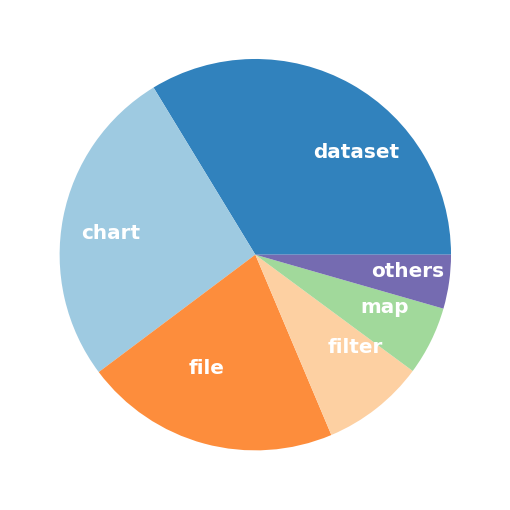

In [36]:
#Create a pie chart

pltdf = dftype.type.value_counts() #uses matlibplot to count rows for each type

pltdftype = pd.DataFrame({'descriptor':'assetTypes','unit':pltdf.index, 'value':pltdf.values}) #Converts the series to a dataframe and adds a column for the longitudinal dataset
pltdftype.sort_values(by=['value'], ascending=False)
pltdf2 = pltdftype[:5].copy() #Put top 5 types in a new dataframe


# Takes the less common types and adds those counts into a value named others.
new_row = pd.DataFrame(data = {
    'unit' : ['others'],
    'value' : [pltdftype['value'][5:].sum()]
})


pltdf2 = pd.concat([pltdf2, new_row], sort=True) #Add the 'others' value to the top 5 dataframe

#https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html
#https://matplotlib.org/3.1.1/tutorials/introductory/pyplot.html
#http://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot

#Color Maps: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

#plot the types
plt.rcParams["figure.figsize"] = [16,9]
cs=cm.tab20c(np.arange(6)/8.)
pltdf2.plot(y='value', kind='pie', labels=pltdf2.unit, colors=cs, legend=False, textprops={'fontsize': 20, 'color':'white', 'weight':'bold'}, labeldistance=0.6)
plt.ylabel('') #Gets rid of the "Counts label"

### Dataframe of proportions
So that you can see actual values

In [37]:
dftypep = dftype.type.value_counts()
dftypep = dftypep.to_frame()
dftypep['percent'] = dftypep.type / dftypep.type.sum()
print(dftypep)

                type   percent
dataset          902  0.337070
chart            710  0.265321
file             565  0.211136
filter           228  0.085202
map              152  0.056801
federated_href    39  0.014574
href              30  0.011211
datalens          23  0.008595
form              12  0.004484
story              9  0.003363
visualization      4  0.001495
calendar           2  0.000747


## Categories for All Assets

In [38]:
#Set up a list of all the types

catlist=[] #dim masterlist as a empty list

for i in d:  #d is the dictionary of parsed json
        if len(i['resource']['id'])==9: #Basically, is the identifier legitimate?
            catlist.append(i['classification'].get('domain_category', 'No Value'))


catlist.sort()
print("List built:", len(catlist),"elements") #print how many elements are in dtlist

List built: 2676 elements


In [39]:
#Convert the list to a dataframe
dfcat = pd.DataFrame(catlist, columns = ['category'])
dfcat.head()

,category
0,Agriculture
1,Consumer Protection
2,Consumer Protection
3,Consumer Protection
4,Consumer Protection


Text(0, 0.5, '')

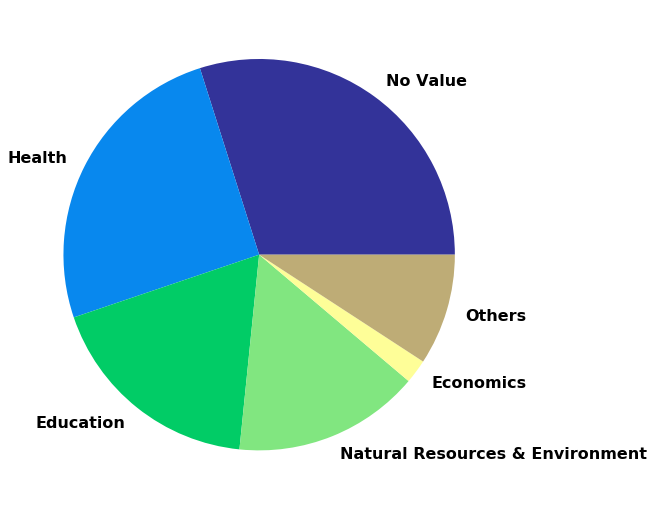

In [40]:
#Create a pie chart

pltdf = dfcat.category.value_counts() #uses matlibplot to count rows for each type

pltdfcat = pd.DataFrame({'descriptor':'assetCategories','unit':pltdf.index, 'value':pltdf.values}) #Converts the series to a dataframe

pltdf2 = pltdfcat[:5].copy() #Put top 5 types in a new dataframe


# Takes the less common types and adds those counts into a value named others.
new_row = pd.DataFrame(data = {
    'unit' : ['Others'],
    'value' : [pltdfcat['value'][5:].sum()]
})


pltdf2 = pd.concat([pltdf2, new_row], sort=False) #Add the 'others' value to the top 5 dataframe

#https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html
#https://matplotlib.org/3.1.1/tutorials/introductory/pyplot.html
#http://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot


#plot the types
cs=cm.terrain(np.arange(6)/8.)
pltdf2.plot(y='value', kind='pie', colors=cs, labels=pltdf2.unit, legend=False, textprops={'fontsize': 16,'weight':'bold'})
plt.ylabel('')

### Dataframe of proportions
So that you can see actual values

In [41]:
dfcatp = dfcat.category.value_counts()
dfcatp = dfcatp.to_frame()
dfcatp['percent'] = dfcatp.category / dfcatp.category.sum()
print(dfcatp)

                                 category   percent
No Value                              800  0.298954
Health                                677  0.252990
Education                             487  0.181988
Natural Resources & Environment       413  0.154335
Economics                              53  0.019806
Demographics                           47  0.017564
Public Safety                          41  0.015321
Politics                               35  0.013079
Procurements and Contracts             33  0.012332
Labor                                  32  0.011958
Consumer Protection                    26  0.009716
Transportation                         11  0.004111
Recreation                              8  0.002990
Culture and Community                   6  0.002242
Employment                              6  0.002242
Agriculture                             1  0.000374


## Downloads and Views
Run the first block of code so that it can be added to the longitudinal dataset

In [42]:
downl = []
views = []

for i in d:  #d is the dictionary of parsed json
        if len(i['resource']['id'])==9: #Basically, is the identifier legitimate?
            downl.append(i['resource']['download_count'])

for i in d:  #d is the dictionary of parsed json
        if len(i['resource']['id'])==9: #Basically, is the identifier legitimate?
            views.append(i['resource']['page_views']['page_views_total'])  

print("List built:", len(downl),"download counts") #print how many elements are in dtlist
print("List built:", len(views),"view counts") #print how many elements are in dtlist            

dfuse = pd.DataFrame([downl,views,typelist]).T #build a dataframe with both lists and the category list
dfuse.columns =['downloads','pageviews','type']


List built: 2676 download counts
List built: 2676 view counts


### Plotting is OPTIONAL

### Plot the values

Text(0.5, 0.98, '')

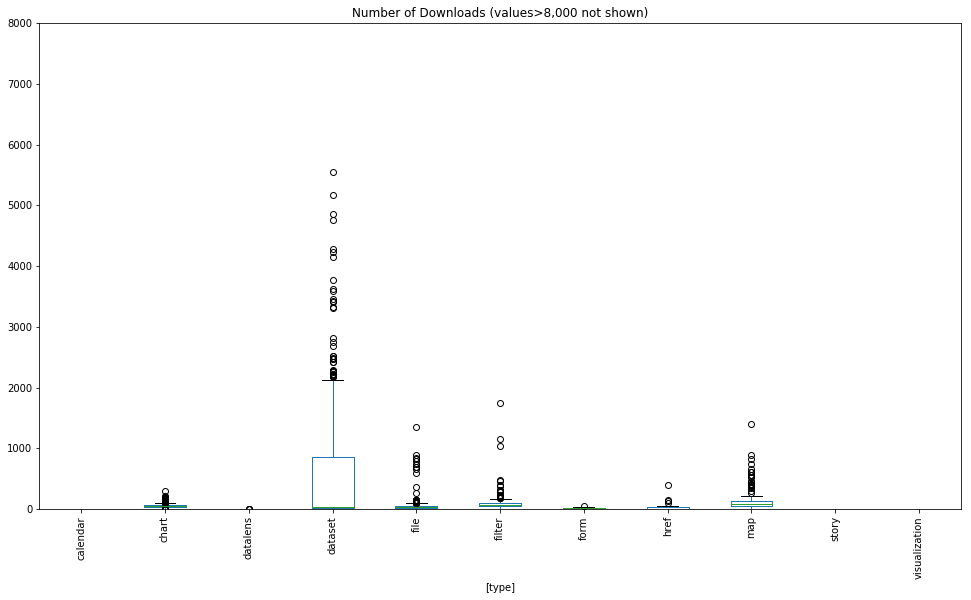

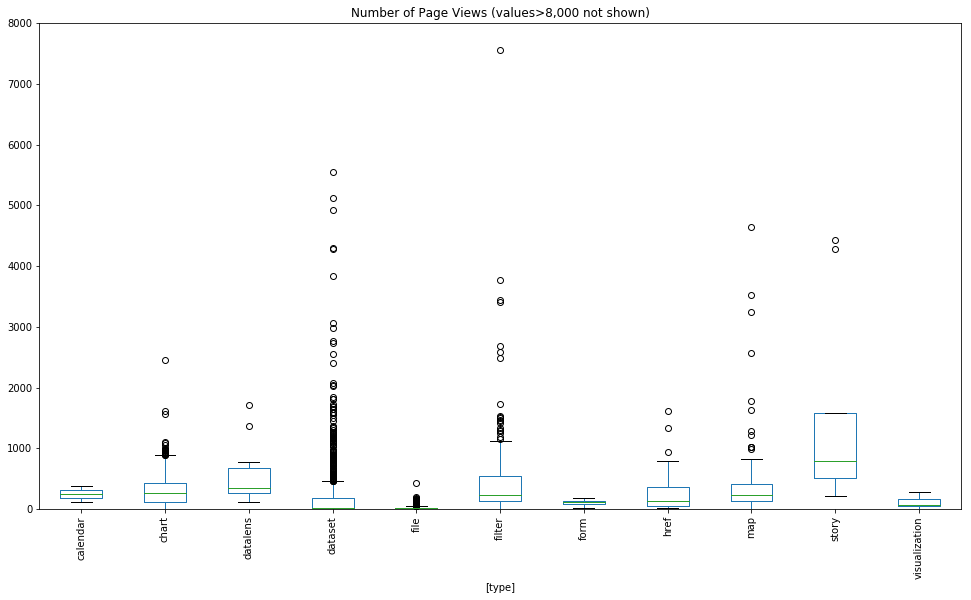

In [14]:
#Traditional boxplots:
dfuse.boxplot(by = ['type'], column=['downloads'], grid=False)
plt.ylim(0,8000)
plt.xticks(rotation=90)
plt.title('Number of Downloads (values>8,000 not shown)')
plt.suptitle("")

dfuse.boxplot(by = ['type'], column=['pageviews'], grid=False)
plt.ylim(0,8000)
plt.xticks(rotation=90)
plt.title('Number of Page Views (values>8,000 not shown)')
plt.suptitle("")



### Plot downloads vs views

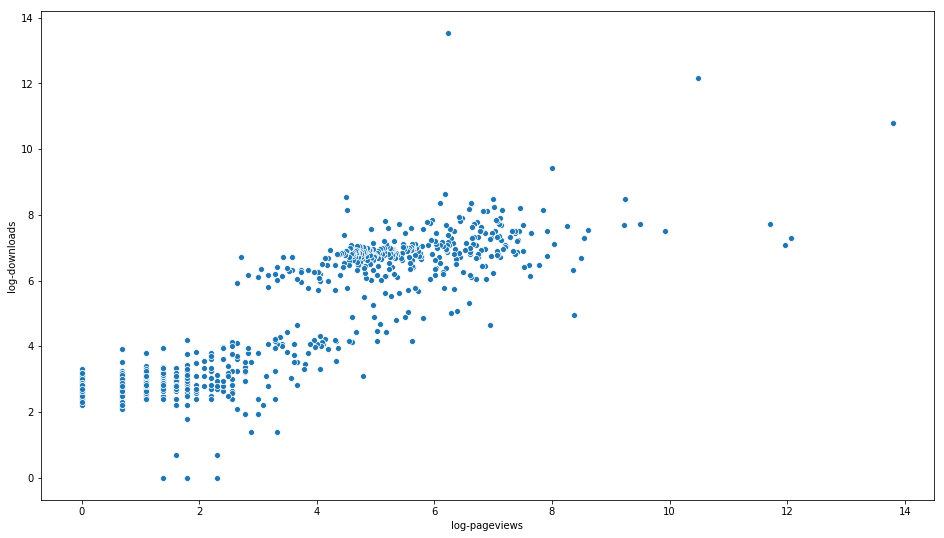

In [15]:
#Calculate logs for downloads and views, only use where use is greater than 0
dfusenum = dfuse[dfuse['type']=='dataset']
dfusenum = dfusenum[dfusenum.downloads > 0]
dfusenum['downloads'] = pd.to_numeric(dfusenum['downloads'])
dfusenum['pageviews'] = pd.to_numeric(dfusenum['pageviews'])
#dfusedataset = dfusenum[dfusenum['type']=='dataset']
#dfusedataset = dfusenum[dfusenum.downloads > 0]
dfusedataset = dfusenum  #I'm sure there is a way cleaner way to do this...
dfusedataset['log-pageviews'] = np.log(dfusenum.pageviews)
dfusedataset['log-downloads'] = np.log(dfusenum.downloads)
sns.scatterplot('log-pageviews', # Horizontal axis
           'log-downloads', # Vertical axis
           data=dfusedataset)



## Assess completion of available metadata elements
The API json does not include the custom metadatafields (or at least I could not figure out how to get them).  The script below downloads detailed metadata for a list of datasets retrieved from the discovery API. 

### Optional: If you already have a csv of metadata to work with open it here
Then skip down to the "Replace the value "Row"..." section

In [43]:
#Open an existing file if you want: (don't run the next script if you do this)
dfmeta = pd.read_csv('WA-METADATA2019-08-20.csv',encoding='cp1252')

#Replace the value "Row" with NaN for rowLabel
#For some reason some datasets have the value "Row" in the rowLabel and it is in the json but not on the url page.
dfmeta['rowLabel'].replace('Row', np.NaN, inplace=True)

### To gather new data, run this to get list of dataset ids

In [14]:
dtlist=[] #dim list as a empty list

for c in d:  #d is the dictionary of parsed json
        if len(c['resource']['id'])==9: #Basically, is the identifier legitimate?
            if c['resource']['type'] == 'dataset':
                dtlist.append(c['resource']['id'])

print("List built:", len(dtlist),"elements") #print how many elements are in dtlist


List built: 866 elements


### Download metadata for each id and create both a csv file and then a dataframe

This takes several minutes to complete. It visits the JSON file for every public dataset included in the list produced above.

In [15]:
# Create a csv file and dataframe

#This function deals with multiply nested json elements in the csv write line below
#https://stackoverflow.com/questions/43491287/elegant-way-to-check-if-a-nested-key-exists-in-a-python-dict
def exists(obj, chain):
    _key = chain.pop(0)
    if _key in obj:
        return exists(obj[_key], chain) if chain else obj[_key]


metadata=open(descriptor+'-METADATA'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.csv', 'w', newline='')
csv.writer(metadata).writerow(['id','owner-uid','name','description','category','attribution','periodOfTime','postingFreq','originator','link','downloadCount','viewCount','licenseId','publicationDate','rowsUpdateAt','tags','rowLabel','metadataLanguage','numberColumns','numColumnDescriptions','numTags'])

for s in dtlist:
    s=requests.get(targeturl+'views/'+s+'.json?$$app_token=OHlDzukOUa15bLYTvOV23hrmX') #build string according to SOCRATA's convention
    r=json.loads(s.text)
    
    colnum = len(r['columns']) #Get number of columns
    
    count = 0
    for q in r['columns']:  #Tally the number of col descriptions that contain a description
        if q.get('description','') != '': #If the description key doesn't exist, default value is '' (don't know why some don't have the key)
            count += 1
    coldesc = count
    #write the values to the csv file. Dates in json files are seconds from jan 1 1970 so datetime.datetime.fromtimestamp converts
    #This has custom fields for data.wa.gov, to use with other portals, you'll have to customize it
    csv.writer(metadata).writerow([r['id'],
        r['owner']['id'],
        r['name'],
        r.get('description'), #For any of these .get(), adding ",'N/A'" will fill the null cells with 'N/A'. However, metadata assessment counts non nulls
        r.get('category'),
        r.get('attribution'),
        exists(r['metadata'],['custom_fields','Temporal','Period of Time']), #See the function 'exists' above
        exists(r['metadata'],['custom_fields','Temporal','Posting Frequency']),
        exists(r['metadata'],['custom_fields','Identification','Originator']),
        r.get('attributionLink'),
        r['downloadCount'],
        r['viewCount'],
        r.get('licenseId'),
        datetime.datetime.fromtimestamp(r['publicationDate']),
        datetime.datetime.fromtimestamp(r.get('rowsUpdatedAt','N/A')),
        r.get('tags','N/A'),
        r['metadata'].get('rowLabel'),
        exists(r['metadata'],['custom_fields','Identification','Metadata Language']),
        colnum,
        coldesc,
        len(exists(r,['tags'])) if exists(r,['tags'])!=None else 0]) #write one line to csv file

metadata.close() #Close the output file, release all locks

#Open up the same file as a dataframe. Encode cp1252 avoids a utf8 error.
dfmeta = pd.read_csv(descriptor+'-METADATA'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.csv',encoding='cp1252')

print('The resulting dataframe has',len(dfmeta),' rows')

The resulting dataframe has 866  rows


### Replace the value "Row" with NaN for rowLabel
For some reason some datasets have the value "Row" in the rowLabel and it is in the json but not on the url page.

In [44]:
dfmeta['rowLabel'].replace('Row', np.NaN, inplace=True)

### How complete are available metadata elements?
'description','category','attribution','periodOfTime','postingFreq','originator','link','licenseId','tags','rowLabel', 'metadataLanguage'


Text(0.5, 0.9, 'Available Metadata Elements Out of 11')

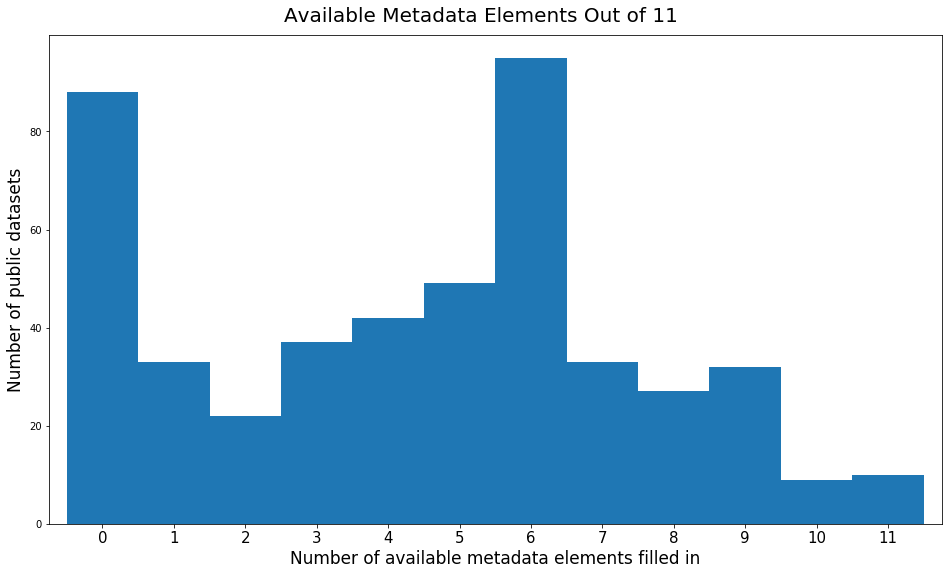

In [45]:
#Available metadata dataframe of public datasets
#dfmeta['numColumnDescriptions'].replace(0, np.nan, inplace = True)

#Count number of available metadata fields filled (not NaN)(and subtract the uid, owner-uid, name, downloads, views, pub date, update date, num columns, col desc, num tags; All of which should be filled)
adfmetas1 = dfmeta.count(axis='columns')-10

#Converts the series to a dataframe
adfmetacts = pd.DataFrame({'origIndex':adfmetas1.index, 'value':adfmetas1.values})

adfmetacts2 = adfmetacts.value.value_counts() #uses matlibplot to count rows for each count

#Converts the series to a dataframe

adfmetacts3 = pd.DataFrame({'descriptor':'availableMetadataComplete','unit':adfmetacts2.index, 'value':adfmetacts2.values})
 
adfmeta = adfmetacts3.sort_values('unit',ascending=True) #sort the rows

#plot the counts

#Font Size
ftsz = 15

#Plot it all
plt.rcParams["figure.figsize"] = [16,9]
adfmeta.plot(y='value', kind='bar', x='unit', width=1.0, legend=False)
plt.ylabel('Number of public datasets', fontsize=(ftsz+2)) #Gets rid of the "Counts lable"
plt.xlabel('Number of available metadata elements filled in', fontsize=(ftsz+2))
#plt.rc('xtick', labelsize=12)
plt.xticks(rotation=0, fontsize=ftsz)
plt.figtext(.5,.9,'Available Metadata Elements Out of 11', fontsize=(ftsz+5), ha='center')

### Create a table of the number of metadata elements

([<matplotlib.axis.XTick at 0x1d09ed11908>,
 <a list of 12 Text xticklabel objects>)

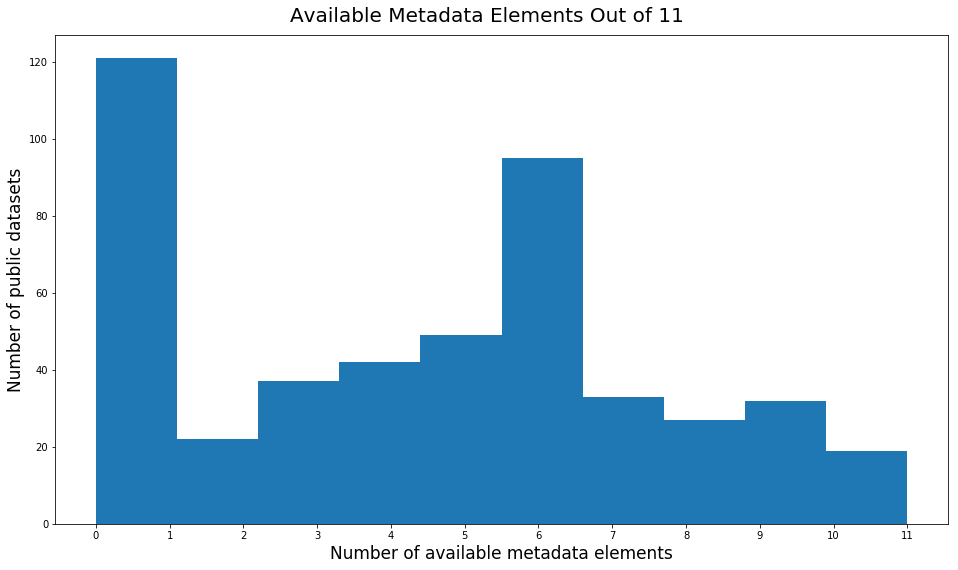

In [46]:
#plot the counts in a histogram

#Font Size
ftsz = 15


#Plot it all
plt.rcParams["figure.figsize"] = [16,9]
adfmetacts.hist('value')
plt.grid(b=None)
plt.ylabel('Number of public datasets', fontsize=(ftsz+2))
plt.xlabel('Number of available metadata elements', fontsize=(ftsz+2))
plt.title('')
plt.figtext(.5,.9,'Available Metadata Elements Out of 11', fontsize=(ftsz+5), ha='center')
plt.xticks(np.arange(min(adfmetacts['value']), max(adfmetacts['value'])+1, 1.0))


### Create table of available metadata

In [47]:
adfmetarow = dfmeta.count('rows')

adfmetaea = pd.DataFrame({'descriptor':'availableMetadataElements', 'unit':adfmetarow.index, 'value':adfmetarow.values}) #Converts the series to a dataframe

adfmetaea['percentYes'] = adfmetaea['value']/len(dfmeta) * 100 
adfmetaea['percentNo'] = 100 - adfmetaea['percentYes']

adfmetaea2 = adfmetaea.iloc[1:] #Get rid of id row

adfmetaea3 = adfmetaea2.sort_values('value',ascending=False) #sort the rows
adfmetaea3.reset_index(drop=True, inplace=True) #resets index and deletes old index

adfmetaea3.drop(adfmetaea3.index[[0,1,2,3,4,5,7,8]], inplace=True) #Remove uneccessary columns. Use adfmetaeaALL = adfmetaea2.sort_values('value',ascending=False) to get a list of all the values

adfmetaea3.head(12)


,descriptor,unit,value,percentYes,percentNo
6,availableMetadataElements,name,477,100.000000,0.000000
9,availableMetadataElements,category,334,70.020964,29.979036
10,availableMetadataElements,tags,330,69.182390,30.817610
11,availableMetadataElements,description,318,66.666667,33.333333
12,availableMetadataElements,attribution,299,62.683438,37.316562
13,availableMetadataElements,link,201,42.138365,57.861635
14,availableMetadataElements,licenseId,158,33.123690,66.876310
15,availableMetadataElements,postingFreq,152,31.865828,68.134172
16,availableMetadataElements,periodOfTime,137,28.721174,71.278826
17,availableMetadataElements,rowLabel,104,21.802935,78.197065


Text(5, 872, 'Total number of datasets = 866')

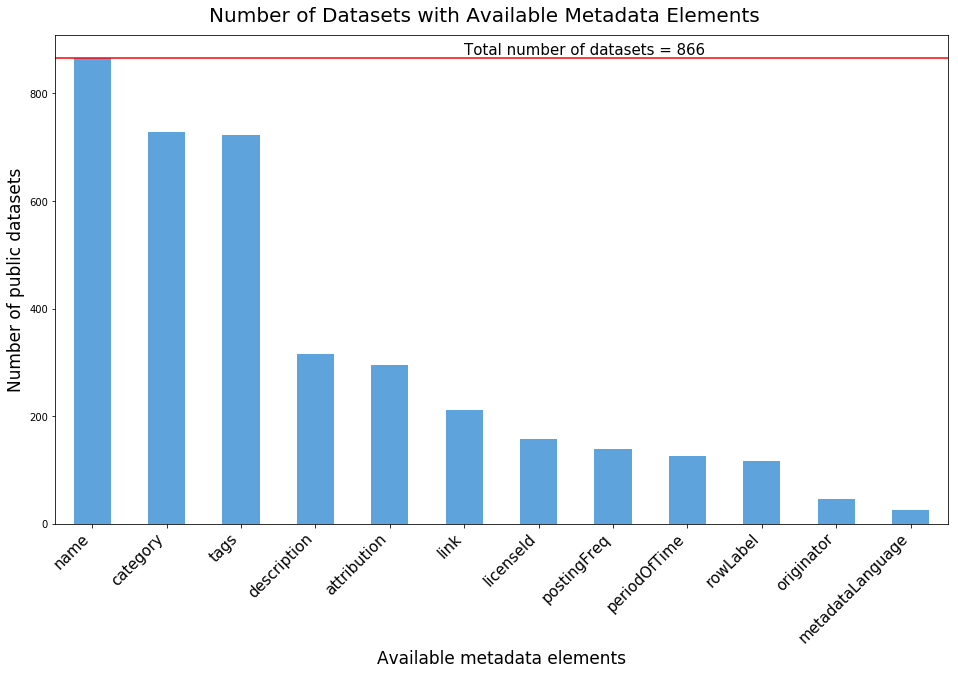

In [20]:
#plot the counts

#Font Size
ftsz = 15

datasetcount = adfmetaea3.iloc[0]['value'] #Gets the number of datasets to make the horizontal line

#plot the counts
plt.rcParams["figure.figsize"] = [16,9]
adfmetaea3.plot(y='value', kind='bar', x='unit', color='#5ea3db', legend=False)
plt.ylabel('Number of public datasets', fontsize=(ftsz+2))
plt.xlabel('Available metadata elements', fontsize=(ftsz+2))
#plt.rc('xtick', labelsize=12)
plt.xticks(rotation=45, fontsize=ftsz, horizontalalignment='right')
plt.figtext(.5,.9,'Number of Datasets with Available Metadata Elements ', fontsize=(ftsz+5), ha='center')
plt.axhline(y=datasetcount, color='r', linestyle='-')
plt.text(5,datasetcount+6,'Total number of datasets = '+str(datasetcount), fontsize=(ftsz))

### How complete are core metadata elements?
Description, Category, Posting Frequency, and Attribution (data_provided_by), license

Text(21.085450346420323, 0, '11.0% of datasets with zero core elements')

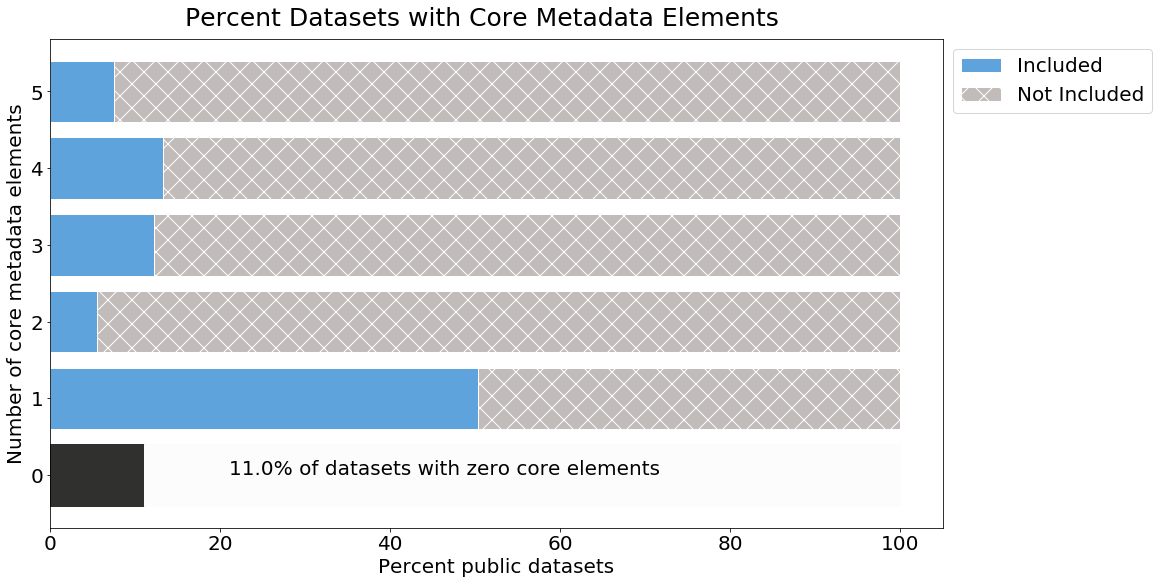

In [21]:
#Core Metadata DataFrame
cdfmetaorig = dfmeta[["id",
"description",
"category",
"postingFreq",
"attribution",
"licenseId"]]

#Count number of core metadata elements filled (not NaN)(and subtract the uid)
cdfmetas1 = cdfmetaorig.count(axis='columns')-1

cdfmeta = pd.DataFrame({'origIndex':cdfmetas1.index, 'value':cdfmetas1.values}) #Converts the series to a dataframe

cdfmetas2 = cdfmeta.value.value_counts() #uses matlibplot to count rows for each count

cdfmetacts = pd.DataFrame({'descriptor':'coreMetadataComplete','unit':cdfmetas2.index, 'value':cdfmetas2.values}) #Converts the series to a dataframe- this is used in the log file for longitudinal analysis

cdfmetafnl = cdfmetacts.sort_values('unit',ascending=True) #sort the rows

#Set up percent yes and no
cdfmetafnl['percentYes'] = cdfmetafnl['value']/len(dfmeta) * 100 
cdfmetafnl['percentNo'] = 100 - cdfmetafnl['percentYes']

#plot the counts

#Font Size
ftsz = 20
plt.rcParams["figure.figsize"] = [16,9]
#cdfmeta.plot(y='value', kind='bar', x='unit', legend=False, title='Core elements out of 4')
# Create Yes bars
yese = plt.barh(cdfmetafnl['unit'], cdfmetafnl['percentYes'], color='#5ea3db', edgecolor='white', label='Included')
# Create No bars
nos = plt.barh(cdfmetafnl['unit'], cdfmetafnl['percentNo'], left=cdfmetafnl['percentYes'], color='#c1bbba', edgecolor='white', label='Not Included', hatch="x")
# #f79d82, red=cc5250

plt.xlabel('Percent public datasets', fontsize=ftsz) #Gets rid of the "Counts lable"
plt.ylabel('Number of core metadata elements', fontsize=ftsz)
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, fontsize=ftsz)
plt.xticks(fontsize=ftsz)
plt.yticks(fontsize=ftsz)
plt.figtext(.5,.9,'Percent Datasets with Core Metadata Elements', fontsize=(ftsz+5), ha='center')
#Change the color of the 0 metadata elements bar so that it only shows no:
nos[0].set_color('#fcfcfc')  
yese[0].set_color('#30302e')
#Add some explanatory text by getting the percent zero elements filled in
zeroelements = cdfmetafnl.iloc[0]['percentYes']
plt.text(zeroelements+10,0,str(round(zeroelements,0))+'% of datasets with zero core elements', fontsize=(ftsz))


Text(0.5, 0.9, 'Percent Datasets with each Core Metadata Element')

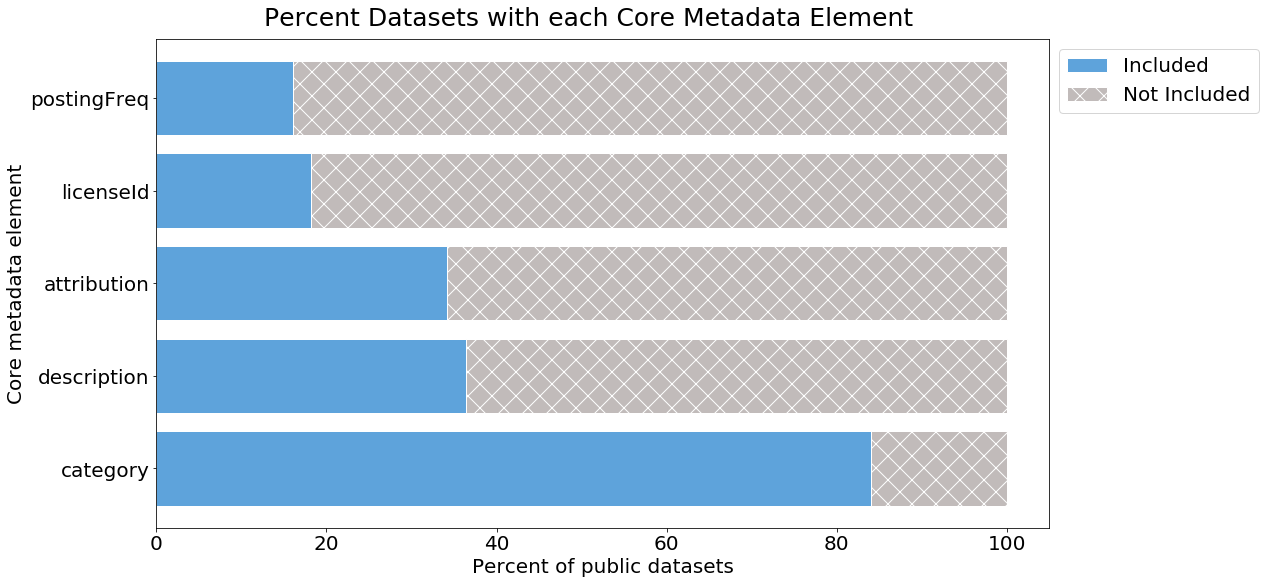

In [22]:
#Look at each core element
# Count the number of not null values for each column - Description, Category, Posting Frequency, and Attribution
coremeta = cdfmetaorig.count('rows')

coremeta1 = pd.DataFrame({'origIndex':coremeta.index, 'value':coremeta.values}) #Converts the series to a dataframe

coremeta1['percentYes'] = coremeta1['value']/len(dfmeta) * 100 
coremeta1['percentNo'] = 100 - coremeta1['percentYes']

coremeta2 = coremeta1.iloc[1:] #Get rid of id row

coremeta3 = coremeta2.sort_values('value',ascending=False) #sort the rows

#plot the counts

#Font Size
ftsz = 20

# Create Yes bars
plt.barh(coremeta3['origIndex'], coremeta3['percentYes'], color='#5ea3db', edgecolor='white', label='Included')
# Create No bars
plt.barh(coremeta3['origIndex'], coremeta3['percentNo'], left=coremeta3['percentYes'], color='#c1bbba', edgecolor='white', label='Not Included', hatch="x")


#coremeta3.plot(y='percentYes', kind='bar', x='origIndex', legend=False, title='Datasets with Completed Element')
#coremeta3.plot(y='percentNo', bottom='percentYes' kind='bar', x='origIndex', legend=False, title='Datasets with Completed Element')
plt.xlabel('Percent of public datasets', fontsize=ftsz) #Gets rid of the "Counts lable"
plt.ylabel('Core metadata element', fontsize=ftsz)
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, fontsize=ftsz)
plt.xticks(fontsize=ftsz)
plt.yticks(fontsize=ftsz)
plt.figtext(.5,.9,'Percent Datasets with each Core Metadata Element', fontsize=(ftsz+5), ha='center')

### View table of the core metadata elements

In [23]:
coremeta3.head()

,origIndex,value,percentYes,percentNo
2,category,728,84.064665,15.935335
1,description,315,36.374134,63.625866
4,attribution,296,34.180139,65.819861
5,licenseId,157,18.129330,81.870670
3,postingFreq,139,16.050808,83.949192


## Keyword Analysis

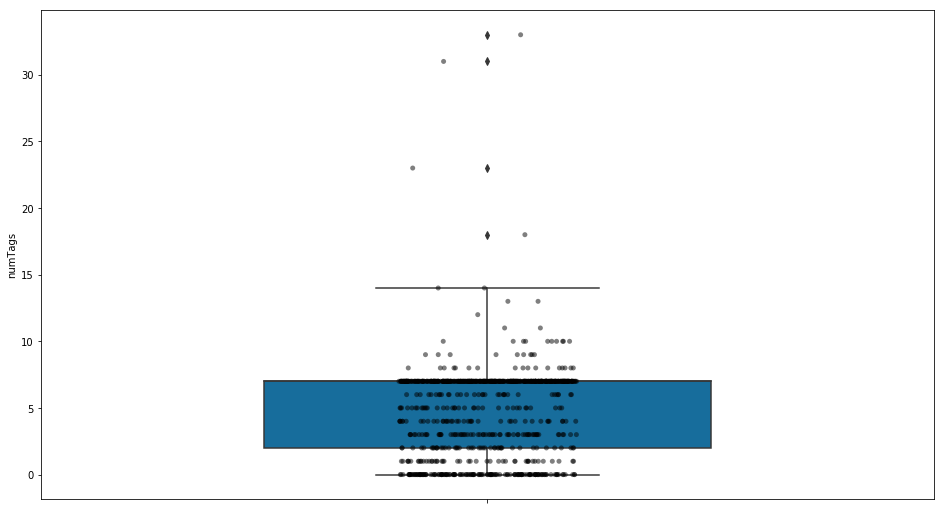

In [24]:
#Plot using Seaborn
bplot = sns.boxplot(y='numTags', data=dfmeta,
                 width=0.5,
                 palette="colorblind")

# add stripplot to boxplot with Seaborn
bplot=sns.stripplot(y='numTags', data=dfmeta, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black')

# Set up dataframe for longitudinal tracking

## Set up csv file to track values longitudinally

This csv file has four columns: download_date, descriptor, unit, value

An example entry would be: 2019-02-23, type, dataset, 509

Or: 2019-05-10, coremetadata-complete, 3, 208

In [25]:
dfusestats = dfuse[dfuse['type']=='dataset']
med = dfusestats.median()
med

downloads    53.0
pageviews    20.0
dtype: float64

In [26]:
#Calculate some summary stats
#calculate median using dataframe created above in the downloads and views section
dfusestats = dfuse[dfuse['type']=='dataset']
med = dfusestats.median()
med = pd.DataFrame({'descriptor':'median','unit':med.index, 'value':med.values})

#calculate mean for views and downloads
mean = dfusestats.mean()
mean = pd.DataFrame({'descriptor':'mean','unit':mean.index, 'value':mean.values})

#calculate standard deviation for views and downloads
stdv = dfusestats.std() 
stdv = pd.DataFrame({'descriptor':'standardDeviation','unit':stdv.index, 'value':stdv.values})

#keywords
tags=pd.DataFrame([dfmeta['numTags']]).T

#calculate mean and median for number of keywords
medtag = tags.median()
medtag = pd.DataFrame({'descriptor':'median','unit':medtag.index, 'value':medtag.values})

#calculate mean for number of keywords
meantag = tags.mean()
meantag = pd.DataFrame({'descriptor':'mean','unit':meantag.index, 'value':meantag.values})

#calculate standard deviation for number of keywords
stdvtag = tags.std()
stdvtag = pd.DataFrame({'descriptor':'standardDeviation','unit':stdvtag.index, 'value':stdvtag.values})

In [27]:
#Append dataframes to a new dataframe
long = pd.DataFrame(columns=['download_date','descriptor','unit','value'])
long = long.append([pltdftype, pltdfcat, adfmeta, cdfmetacts, med, mean, stdv, medtag, meantag, stdvtag], sort=False, ignore_index = True)
long['download_date'] = downloadDate

In [28]:
#append data to csv file
if os.path.isfile('portalLog.csv'):
    long.to_csv('portalLog.csv', header=False, mode = 'a', index=False) #if file exists, append to it without header
else:
    long.to_csv('portalLog.csv', mode = 'w', index=False) #if file does not exist, create it and add header

print('Data appended to file named portalLog.csv')

Data appended to file named portalLog.csv


# Publisher Analysis

Looking to see if there is any correlation between the number of core elements and the number of downloads

In [43]:
#Core Metadata DataFrame
pubdfmeta = dfmeta[["owner-uid",
"downloadCount",
"description",
"category",
"postingFreq",
"attribution",
"licenseId"]]

pubmetric = pubdfmeta.drop(pubdfmeta.columns[2:], axis=1) #dataframe of owner-uid and downloadCount

#Count number of core metadata elements filled (not NaN)(and subtract the owner-uid and downloads)
core = pubdfmeta.count(axis='columns')-2

coredf = pd.DataFrame({'coreCount':core.values}) #Converts the series to a dataframe

#Add the core element counts to the owener-uid dataframe
pubmetric['coreCount'] = coredf

(0, 5000)

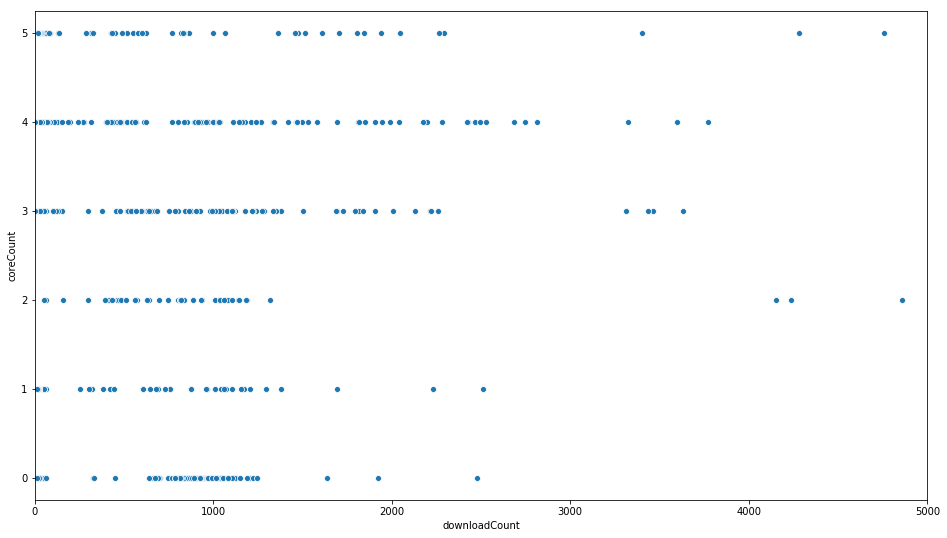

In [44]:
sns.scatterplot('downloadCount', # Horizontal axis
           'coreCount', # Vertical axis
           data=pubmetric)
plt.xlim(0, 5000)